# 0. Introduction

## Overview 



This notebook establishes the **Recurrent Neural Gene Regulatory Networks (RNGRNs)**. The RNGRN system takes inspiration from the Recurrent Neural Chemical Reaction Networks (RNCRNs) work by Alex Dack (https://arxiv.org/abs/2406.03456). 

This system seeks to use gene regulatory network modelling to replicate the spatiotemporal dynamics of Turing pattern formation. Here, we seek to use **Hill functions** of gene activation as a surrogate for **sigmoid activation functions**. This confers our gene regulatory network neural net-like properties, allowing it to 'learn' the spatiotemporal Turing pattern formation of a given target system.

<div style="text-align: center;">
    <img src="Images/Hill.png" alt="Hill" width="60%">
</div>

***


## Background

### Biological patterning

Biological patterning is a majorly unsolved area in biology. Patterning is observed across all scales of life, from microbiology, developmental biology and ecology. 

<div style="text-align: center;">
    <img src="Images/Angelfish.png" alt="Angelfish" width="50%">
</div>

In developmental biology, biological patterns are fundamental in the correct formation of body plans, such as the segmentation of our backbones.

<div style="text-align: center;">
    <img src="Images/Embryo.png" alt="Embryo" width="50%">
</div>

***

### Reaction-Diffusion models

The most widely-accepted mathematical models of biological patterning are reaction-diffusion (RD) models, proposed by Alan Turing in 1952. 

These RD models are coupled systems of PDEs that describe the interaction between two or more chemical species that can diffuse. For 2 chemical species: 

$$
\frac{\partial u}{\partial t} = f(u,v) + D_u \nabla^2 u,\qquad
\frac{\partial v}{\partial t} = g(u,v) + D_v \nabla^2 v,
$$

* $u(\mathbf{x},t)$ and $v(\mathbf{x},t)$ are concentrations of two interacting species, termed morphogens.

* $f,g$ describe the interactions between morphogens

* $D_u, D_v$ are diffusion coefficients

* The Laplacian term $\nabla^2$ models spatial spreading.

***


### Turing patterns

When this diffusion becomes unstable, "Turing patterns" can form and these patterns can be fitted to real-world biology. 

There are two criteria for Turing pattern formation in RD models:

1. Stable steady state in well-mixed conditions 

    If the system was well-mixed, where no diffusion is occuring, then we would have an ODE system:

    $$
    \dot u = f(u,v),\qquad \dot v = g(u,v).
    $$

    When at steady state: 

    $$(u^*, v^*) \text{ satisfies } f(u^*, v^*) = 0 \quad \text{and} \quad g(u^*, v^*) = 0$$

    Introducing a small perturbation:

    $$u(t) = u^* + \delta u(t),\quad v(t) = v^* + \delta v(t),\quad \delta(t) = \begin{pmatrix} \delta u(t) \\ \delta v(t) \end{pmatrix}$$

    Linear stability analysis around $(u^*, v^*)$: 
    $$\frac{d\delta}{dt} = J \delta,\quad J = \begin{pmatrix} f_u & f_v \\ g_u & g_v \end{pmatrix}_{(u^*, v^*)}$$

    The steady state must be stable: 

    $\Re(\lambda_i(J)) < 0$ for all eigenvalues $\lambda_i$.

    This is true when: 

    $$
    \mathrm{tr}(J) < 0,\qquad \det(J) > 0.
    $$

    When well-mixed, the steady states are stable means the system returns to its original state:
    $$\lim_{t \to \infty} \|\delta(t)\| = 0,\quad (u(t), v(t)) \to (u^*, v^*).$$

2. Diffusion-driven instability
    
    When diffusion is present, i.e. we use the PDE system:  

    $$
    \frac{\partial u}{\partial t} = f(u,v) + D_u \nabla^2 u,\qquad
    \frac{\partial v}{\partial t} = g(u,v) + D_v \nabla^2 v,
    $$

    Again, we introduce a small perturbation and use Linear stability analysis - giving the same Jacobian:

    $$J = \begin{pmatrix} f_u & f_v \\ g_u & g_v \end{pmatrix}_{(u^*, v^*)}$$

    But now, we also have a Diagonal diffusion matrix:
    
    $$\quad D = \begin{pmatrix} D_u & 0 \\ 0 & D_v \end{pmatrix}$$

    Considering perturbations with spatial frequency \(k\) (Fourier modes), the spatiotemporal dynamics are governed by the matrix:

    $$
    J - k^2 D.
    $$

    If, for some nonzero \(k\), this matrix has an eigenvalue with positive real part, then the system will be unstable with diffusion. This is true when: 

    $$
    D_u g_v + D_v f_u > 0,
    $$

    and

    $$
    (D_u g_v + D_v f_u)^2 > 4 D_u D_v \det(J).
    $$

    This means that the diffusion-driven instability will amplify noise at the characteristic wavelength ( \(k\) with max positive eigenvalue/growth rate) to produce a pattern at a specific wavelength: 

    $$
    \lambda_{\text{pattern}} \approx \frac{2\pi}{k_{\max}}.
    $$


<div style="text-align: center;">
    <img src="Images/Kondor4.png" alt="Kondor4" width="70%">
</div>


***

### Activator-inhibitor models

Intuitively, reactions create local amplification (short-range activation), while diffusion produces long range suppression. When these effects are balanced appropriately, this produces Turing patterns of spots, stripes, or labyrinths.


Key characteristics of Turing patterns:
- Spontaneously forming (in noise)
- Self-repairing
- Sensitive to model parameters - reaction and diffusion
- Sensitive to domain and boundary conditions

A common form of RD models that produce Turing patterns are the activator-inhibitor models by Gierer and Meinhardt (1972), which describes a slow diffusing activator and a fast diffusing inhibitor. 
- Small noise in the activator leads to positive feedback and peaks of activation. 
- These peaks of activation induce inhibitor production.
- The inhibitor diffuses quickly, leading to zones of inhibition surrounding the peaks of activation. Activator diffuses slowly and is suppressed by the inhibitor.
- Peaks of activation spaced out by a minimum distance. 
- Creates pattern of finite wavelength.


<div style="display: flex; justify-content: center; align-items: center;">
    <img src="Images/Gierer.png" alt="Gierer" style="width: 30%; margin-right: 10px;">
    <img src="Images/Formation.png" alt="Formation" style="width: 30%;">
</div>

***

### Turing patterns in-vitro and in-vivo

Moving from theory to reality, there have been very few instances where these models have been recreated in the lab. Because of the simplicity of these models, they are highly senstitive their parameterisation. Most importantly, they require a large difference in diffusion coefficient between the morphogens. This parameter sensitivity does not pair well with the noise of biological systems.

Here, this study by Mark Isalan's lab shows the 'Turing volume' of a RD model. This refers to the parameter space (of 3 params here that make up the 3 axes) that satisfies the Turing pattern criteria above. When the differential diffusivity (D) between the 2 morphogens is 0.01 (100-fold difference in diffusion coefficient) the Turing volume is already small. However when the differential diffusivity is changed to 0.1 (10-fold difference in diffusion coefficient), this Turing volume becomes tiny, demonstrating the importance of differential diffusivity in Turing pattern formation.

<div style="text-align: center;">
    <img src="Images/Diambra.png" alt="Diambra" width="30%">
</div>

***

### Increasing the robustness of Turing patterns

Recent works by the Isalan and Endres groups have shown that larger RD models, composed of more than 2 morphogens are more robust. 
They identified the most robust 3-node network (Scholes 2019), and implemented it in-vitro, as the first example of an in-vitro Turing pattern.

<div style="text-align: center;">
    <img src="Images/Tica.png" alt="Tica" width="30%">
</div>

However, even this model is only theoretically capable of Turing patterns in 0.022% of parameter combinations.

****

### The inverse Turing problem

**The goal of this work is to discover new RD models that produce any biological pattern that we desire. The RNGRN system is a neural network that has an architecture inspired by gene regulatory networks (GRN), thus the idea is that given any biological pattern, can we predict a GRN, and its associated parameters, that would produce this specific pattern?**

**Furthermore, we are interested in knowing the Turing robustness of these predicted GRNs - and can this robustness be improved??**

****

## RNGRN system

### Central dogma
Consider a conventional gene. It codes for a specific gene product (usually a protein) and the production of this gene product (AKA gene expression) is under tight control. Specific transcripton factors will bind to the enhancer or operator of this gene to upregulate or downregulate gene expression. There will be 'noisy/stochastic' basal gene expression - baseline gene expression level that occurs irrespective of the gene's regulation. 

****



### Gene regulatory networks
Taking a systems biology perspective here, gene regulatory networks arise when a set of genes regulate each other's gene expression. One such form of network can arise when the gene product of one gene is a transcription factor that can bind to the upstream region of another gene in the network to influence its gene expression.

****

### Background Concept of RNGRNs

This work is based on Alex Dack's RNCRNs (the chemical reaction network equivalent of RNGRNs). Here, he sought to develop a framework that allows for the design of DNA-strand displacement reactions that model temporal dynamics. **You might need to read the paper to fully understand this: https://arxiv.org/abs/2406.03456**

In Alex's work he considers 2 types of chemical species:
- Executive species 𝑋 - 'main' chemical species whose dynamics approximate the target system
- Chemical perceptrons 𝑌 - auxiliary chemical species that change concentration rapidly and modulate the executive species concentrations
- These species would have subscripts $i$ and $j$, respectively, referring to multiple species of Executive species $X_i$ and Chemical perceptrons $Y_j$

In these chemical reaction networks, these executive species $X_i$ and chemical perceptrons $Y_j$ would interact **catalytically**, where one type catalyses the production or degradation of the other type, and vice versa. Each interaction has its own unique reaction rate coefficient.

The CRN was designed specifically such that when the chemical perceptrons were at steady state, their concentration would model a 'perceptron' with a 'smoothed ReLU' activation function; they called this the chemical perceptron. 

What this means: 
- A perceptron is the original neurone of an artificial neural network that that takes the weighted mean of its inputs (and a bias), then applies a non-linear activation function. This enables the system to learn non-linear behaviours and dynamics.

<div style="text-align: center;">
    <img src="Images/Perceptrons.png" alt="Perceptrons" width="50%">
</div>

- The chemical perceptron had the same activity, where it would take the weighted mean of each executive species (where the weights corresponds to reaction rate coefficients of production/degradation of $X_i$ and the input is the $X_i$ concentrations), then apply a ReLU-like function on top of this (constructed by the reactions that $Y_j$ undergoes).

<div style="text-align: center;">
    <img src="Images/CRN.png" alt="CRN" width="70%">
</div>

<div style="text-align: center;">
    <img src="Images/ystar.png" alt="ystar" width="70%">
</div>
<div style="text-align: center;">
    <img src="Images/smooth.png" alt="smooth" width="60%">
</div>

This smoothed-RELU property of the chemical perceptrons when at steady state allows the system to learn temporal dynamics by using a separation of timescales. This is done by controlling a parameter $\mu$ (where $0 \le \mu < 1$), which describes the relative speed of equilibration between executive species and chemical perceptrons:

- Quasi-static approximation - first, we make the assumption that chemical perceptrons reach steady state instantaneously ($\mu = 0$). 

    Intuitively, this means the perceptrons will instantly reach steady state concentration at each change of executive species concentration. The perceptrons always be at equilibrium concentration y*.

    In this timescale, the executive species concentrations effectively feedback onto themselves, using the chemical perceptrons as an intermediary.

    The RNCRN can act as a neural network, where the CRN parameters needed to produce the target dynamics can be trained using backpropagation. 

<div style="text-align: center;">
    <img src="Images/QSA.png" alt="QSA" width="70%">
</div>

- Dynamical approximation - next, we assume that the chemical perceptrons equilibrate quickly, but not infinitely quickly - but still much quicker than the executive species ($\mu \ll 1$).

    Now, the idea is that we have a recurrent chemical reaction network, where the executive species and chemical perceptrons repeatedly modulate each other's concentrations such that the executive species dynamics follows that of the target system.

    The smaller the value of $\mu$, the theoretically closer the simulation will be to the target system, because this gets closer towards the neural net-like conditions that it was trained on.
    
<div style="text-align: center;">
    <img src="Images/DA.png" alt="DA" width="70%">
</div>

The key advantage of the RNCRNs (as opposed to other bio/chem dynamics-approximating ML systems) is it's experimental transferrability:
- The trained parameters are reaction rate coefficients.
- The initial conditions of the chemical perceptrons is arbitrary. This means fine-tuning of initial conditions is not necessary.

****

### Adapting RNCRNs to spatiotemporal dynamics

To learn spatiotemporal dynamics, the executive species would need to diffuse, thus a diffusion term is added to it's ODE to give a PDE of $X_i$. The diffusion constant ($D_X$) of $X_i$ is trainable.

To maintain the same chemical perceptron steady state equation (y*), the chemical perceptrons are assumed to diffuse infinitely slowly, i.e. they are localised to a single grid-point in space.
****

### RNGRNs 

The RNGRNs rely on the idea that the expression of a gene and the diffusion of the corresponding gene product is on a much slower timescale than the binding dynamics that occur between a transcription factor and its complementary regulatory binding site. 

Now, our executive species are modelled as transcription factors $X_j$, while our chemical perceptrons are the gene regulatory sites (reffered hereon as promoters) $G_i$ of these transcription factors. We create a GRN of size $N$ where these transcription factors bind to each other's (and their own) promoter to up/downregulate gene expression.

Each promoter can be in 3 possible states:
$G_{i,\text{free}}$, $G_{ij,A}$ or $G_{ij,R}$, which signify an unbound promoter, activated promoter or repressed promoter (no expression), respectively. The $j$ is added to $G_{ij,A}$ and $G_{ij,R}$ to denote the transcription factor bound to $G_i$.

Total promoter count is normalised:
$$1 = G_{i,\text{tot}} = G_{i,\text{free}} + \sum_j G_{ij,A} + \sum_j G_{ij,R}$$

To be able to maintain the ability to learn non-linear dynamics, we propose that these transcription factors $X_j$ dimerise to be able to bind to a promoter region. This introduces cooperativity into the binding dynamics. To simplify the number of parameters present, we assume a tri-molecular interaction between 2 transcription factors of the same identity $X_j$ and a free promoter $G_{i,\text{free}}$. **Each individual $i,j$ interaction can be either (but not both) a activation or repression interaction.**
 
$$2x_j + G_{i,\text{free}} \rightleftharpoons^{k_{ij,A}^+}_{k_{ij,A}^-} G_{ij,A} \qquad 2x_j + G_{i,\text{free}} \rightleftharpoons^{k_{ij,R}^+}_{k_{ij,R}^-} G_{ij,R}$$

Therefore, the rate of change of activated/repressed promoters can be expressed as: 
$$\frac{dG_{ij,A}}{dt} = k_{ij,A}^+ x_j^2 G_{i,\text{free}} - k_{ij,A}^- G_{ij,A}$$
$$\frac{dG_{ij,R}}{dt} = k_{ij,R}^+ x_j^2 G_{i,\text{free}} - k_{ij,R}^- G_{ij,R}$$

Assuming $\alpha$ represents strength of gene activation coefficient, the rate of change of executive species is: 

$$\frac{\partial x_i}{\partial t} = \beta_i + \sum_j \alpha_{ij} G_{ij,A} - \delta_i x_i + D_{x_i} \nabla^2 x_i$$

where $\beta_i$ the basal gene expression coefficient, $\delta_i x_i$ is the rate of executive species degradation with its own degradation coefficient $\delta_i$. The diffusion term is added at the end: $D_{x_i}$ is the diffusion coefficient, and $\nabla^2 x_i$ represents spatial spreading.

Note that an assumption we make is that $G_{i,\text{tot}} \ll x_j$, to be able to neglect $x_i$ sequestration.

****

### Quasi-static approximation ($\mu = 0$)

Making the Quasi-steady state assumption that gene expression occurs on a much slower timescale than transcription factor-promoter binding $(\frac{dG_{ij,A}}{dt}, \frac{dG_{ij,R}}{dt}, \mu \approx 0)$: 

$$G_{i,A}^* = \frac{\sum_j K_{ij,A} x_j^2}{1 + \sum_j K_{ij,A} x_j^2 + \sum_j K_{ij,R} x_j^2}$$

Where the rate constants have been combined into binding constants:

$$K_{ij,A} = \frac{k_{ij,A}^+}{k_{ij,A}^-} \qquad K_{ij,R} = \frac{k_{ij,R}^+}{k_{ij,R}^-}$$

Note that the $G_{i,A}^*$ steady state is in the form of a hill function of $n=2$, letting us model a sigmoid activation function. 

<div style="text-align: center;">
    <img src="Images/Hill.png" alt="Hill" width="60%">
</div>

Thus at quasi-steady state, the change in executive species can be expressed as:

$$\frac{\partial x_i}{\partial t} = \beta_i + \left( \frac{\sum_j \alpha_{ij} K_{ij,A} x_j^2}{1 + \sum_j K_{ij,A} x_j^2 + \sum_j K_{ij,R} x_j^2} \right) - \delta_i x_i + D_{x_i} \nabla^2 x_i$$


### Dynamical approximation ($\mu \ll 1$).

Without the QSS assumption, the base GRN can be expressed as: 

$$G_{i,\text{free}} = 1 - \sum_j G_{ij,A} - \sum_j G_{ij,R}$$
$$\mu \frac{dG_{ij,A}}{dt} = k_{ij,A}^+ x_j^2 G_{i,\text{free}} - k_{ij,A}^- G_{ij,A}$$
$$\mu \frac{dG_{ij,R}}{dt} = k_{ij,R}^+ x_j^2 G_{i,\text{free}} - k_{ij,R}^- G_{ij,R}$$
$$\frac{\partial x_i}{\partial t} = \beta_i + \sum_j \alpha_{ij} G_{ij,A} - \delta_i x_i + D_{x_i} \nabla^2 x_i$$

Note the inclusion of $\mu$, which describes the relative rate of equilibration of promoter binding relative to the executive species production.

# 1.Setup

## Import Libs

In [1]:
###Import libs
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from scipy.optimize import fsolve




In [2]:
###Use GPU
print("Num GPUs Available: ", torch.cuda.device_count())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Num GPUs Available:  1
Using device: cuda


In [3]:
###Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)

## Initialise solver

The solver bit is a bit complex. Solving common reaction-diffusion systems is already difficult, but when we train our RNGRN with tens of species and hundereds of parameters, the solving can become very unstable, especially in the reactions. 

Here, we try to use as robust of a solver as possible; a BDF1 (Backward Differentiation Formula of order 1) time integrator with Newton-Krylov linear solves. 

This section shouldn't need to be touched unless the solving is too slow and convergenvce thresholds need to be relaxed.

### Generic functions

In [4]:
###Define laplacian operator
def laplacian(field, dx):
        # Assume periodic boundaries
        lap = (torch.roll(field, 1, 0) + torch.roll(field, -1, 0) +
               torch.roll(field, 1, 1) + torch.roll(field, -1, 1) - 4 * field) / (dx ** 2)
        return lap

Parameter - save_interval - how frequently the trajectory is saved to CPU RAM

In [5]:
###Define BDF1 time integrator with Newton-Krylov linear solves 
def bdf1_newton_krylov(X0, dt, Tmax, rhs_func, jvp_func=None, tol=1e-3, max_iter=10, gmres_max_iter=200, save_interval=1):
    steps = int(Tmax / dt)
    X = X0.clone()
    trajectory = []

    #Loop through time steps
    for step in range(steps):

        #Save trajectory at interval
        if step % save_interval == 0:
            trajectory.append(X.clone().cpu())

        #Print progress at interval
        print_interval = 1000
        if print_interval and (step % print_interval) == 0:
            print(f"Simulation progress: step {step+1}/{steps}")

        # Initial guess for Newton's method
        X_n = X.clone()
        f_n = rhs_func(X_n)
        X_guess = X_n + dt * f_n

        # Prepare Jacobian Vector Product function
        jvp_func = make_autograd_jvp(rhs_func)

        # Newton iterations
        for newton_iter in range(max_iter):
            #Compute residual
            f_val = rhs_func(X_guess)
            G = X_guess - dt * f_val - X_n

            #Check convergence
            if torch.norm(G) < tol:
                if step % print_interval == 0:  # print Newton convergence info at same interval
                    print(f"Newton converged in {newton_iter+1} iterations at step {step+1}")
                break

            #Solve for Newton update using GMRES
            A = lambda v: jvp_func(v, X_guess, dt)
            b_gmres = -G
            P = lambda v: v
            w = gmres_torch(A, b_gmres, P=P, tol=tol, max_iter=gmres_max_iter)
            X_guess += w
        else:
            print(f"Newton did not converge at step {step+1} after {max_iter} iterations")
            
        # Update solution
        X = X_guess.clone()


    return trajectory

In [6]:
###Generalized Minimal Residual (GMRES)
def gmres_torch(A, b, P=None, tol=1e-6, max_iter=200):
    #Initialise variables
    if P is None:
        P = lambda v: v
    n = b.shape[0]
    Q = torch.zeros((n, max_iter+1), dtype=b.dtype, device=b.device)
    H = torch.zeros((max_iter+1, max_iter), dtype=b.dtype, device=b.device)

    #GMRES iterations
    x = torch.zeros_like(b)
    r0 = b - A(x)
    r = P(r0)
    beta = torch.norm(r)
    if beta == 0:
        return x
    Q[:, 0] = r / beta

    #Arnoldi process
    for k in range(max_iter):
        q = P(A(Q[:, k]))
        for i in range(k+1):
            H[i, k] = torch.dot(Q[:, i], q)
            q = q - H[i, k] * Q[:, i]
        h = torch.norm(q)
        H[k+1, k] = h
        if h < 1e-12:
            break
        Q[:, k+1] = q / h

        e1 = torch.zeros(k+2, dtype=b.dtype, device=b.device)
        e1[0] = beta
        H_small = H[:k+2, :k+1]
        y, *_ = torch.linalg.lstsq(H_small, e1)
        x = Q[:, :k+1] @ y

        res_norm = torch.norm(P(b - A(x)))
        if res_norm < tol:
            break
    return x

In [7]:

###Autograd JVP factory and wrappers
def make_autograd_jvp(rhs_func):
    def jvp(v, X, dt):
        X_req = X.detach().requires_grad_(True)
        _, Jv = torch.autograd.functional.jvp(rhs_func, (X_req,), (v,), create_graph=False)
        return v - dt * Jv
    return jvp



### Set up RNGRN system

Here, we define the 'full' RNGRN system  equations (no quasi-static approximation) for numerical simulation.

In [8]:
###Define RNGRN equations
def rhs_perceptron(X):
    n = n_cells
    n_nodes = n * n
    nx = N * n_nodes  
    nG_per_type = N * N * n_nodes  
    nG_total = 2 * nG_per_type
    
    # Unpack X
    x = X[:nx].view(N, n_nodes)  
    G_A = X[nx:nx + nG_per_type].view(N, N, n_nodes) 
    G_R = X[nx + nG_per_type:].view(N, N, n_nodes) 
    
    # Compute G_free for each i
    G_free = 1.0 - G_A.sum(dim=1) - G_R.sum(dim=1)  
    
    # x dynamics with diffusion + reaction
    xdot = torch.zeros_like(x)
    for i in range(N):
        lap_x = D[i] * laplacian(x[i].view(n, n), dx)
        prod = beta[i] + (alpha[i].unsqueeze(1) * G_A[i]).sum(dim=0) - delta[i] * x[i]
        xdot[i] = lap_x.flatten() + prod
    
    # G dynamics using trimolecular binding
    Gdot_A = torch.zeros_like(G_A)
    Gdot_R = torch.zeros_like(G_R)
    for i in range(N):
        for j in range(N):
            Gdot_A[i, j] = (kA_plus[i, j] * x[j]**2 * G_free[i] - kA_minus[i, j] * G_A[i, j]) / mu
            Gdot_R[i, j] = (kR_plus[i, j] * x[j]**2 * G_free[i] - kR_minus[i, j] * G_R[i, j]) / mu
    
    return torch.cat([xdot.flatten(), Gdot_A.flatten(), Gdot_R.flatten()])


### Set up target system

**Target system info**

Let's try to approximate the saturated Gierer-Meinhardt Activator-Inhibitor RD model. 

\begin{align*}
\frac{\partial u}{\partial t} &= \nabla^2 u + a + \frac{u^2}{v ( 1 + Ku^2)} - bu, \\
\frac{\partial v}{\partial t} &= D \nabla^2 v + u^2 - cv,
\end{align*}

Parameters to form stripes:
* a = 0.5
* b = 1
* c = 6.1
* K = 0.003
* Du = 1
* Dv = 100



In [9]:
### Define Target system equations
def rhs_target(X):
    n = n_cells
    n_nodes = n * n
    u = X[0:n_nodes].view(n, n)
    v = X[n_nodes:2 * n_nodes].view(n, n)

    lap_u = laplacian(u, dx)
    lap_v = laplacian(v, dx)

    # Gierer-Meinhardt Parameters 
    a = 0.5
    b = 1.0
    c = 6.1
    K = 0.003
    Du = 1.0
    Dv = 100.0

    # Prevent division by zero
    eps = 1e-8
    v_safe = torch.clamp(v, min=eps)

    # Gierer-Meinhardt equations
    du = Du * lap_u + a + (u**2 / (v_safe * (1 + K * u**2))) - b * u
    dv = Dv * lap_v + u**2 - c * v

    return torch.cat([du.flatten(), dv.flatten()])


# 2.Quasi-Static Approximation

## Setup

Parameter - n_cells - dims of target system simulation

Parameter - L - length of simulated space

In [10]:
###Set domain params
n_cells = 10
L = torch.tensor(5.0, dtype=torch.float32, device=device)
dx = float(L) / float(n_cells)

Parameter - dt - size of simulation step in time

Parameter - Tmax - length of time simulated for

In [11]:
###Set target simulation params
dt = torch.tensor(0.001, dtype=torch.float32, device=device)
Tmax = torch.tensor(400.0, dtype=torch.float32, device=device)
steps = int(Tmax / dt)

Parameter - n_species - number of genes in target network

In [12]:
###Set intitial conditions
n_species = 2
init_fields = []
for _ in range(n_species):
    field = torch.clamp(1.0 + 0.1 * torch.randn(n_cells, n_cells, dtype=torch.float32, device=device), min=0.001)
    init_fields.append(field)

X0 = torch.cat([f.flatten() for f in init_fields]).to(device)


## Generate training data

To generate training data, we simulate the target system. It's simulated in a 10x10 grid for simplicity - we would generate too much data if we simulated a larger grid.

In [13]:
###Simulate target system 
trajectory = bdf1_newton_krylov(X0, dt, Tmax, rhs_target, jvp_func=None, save_interval=1)
print(f"Simulation completed with {len(trajectory)} time steps")

Simulation progress: step 1/399999
Newton converged in 2 iterations at step 1
Simulation progress: step 1001/399999
Newton converged in 1 iterations at step 1001
Simulation progress: step 2001/399999
Newton converged in 1 iterations at step 2001
Simulation progress: step 3001/399999
Newton converged in 1 iterations at step 3001
Simulation progress: step 4001/399999
Newton converged in 1 iterations at step 4001
Simulation progress: step 5001/399999
Newton converged in 2 iterations at step 5001
Simulation progress: step 6001/399999
Newton converged in 2 iterations at step 6001
Simulation progress: step 7001/399999
Newton converged in 1 iterations at step 7001
Simulation progress: step 8001/399999
Newton converged in 2 iterations at step 8001
Simulation progress: step 9001/399999
Newton converged in 2 iterations at step 9001
Simulation progress: step 10001/399999
Newton converged in 1 iterations at step 10001
Simulation progress: step 11001/399999
Newton converged in 1 iterations at step 

Calculate laplacian values and instantaneous rates from simulated trajectory.

Parameter - subsample_factor - the frequency of timesteps that are saved for training - e.g. if it's 10 then every 10th timestep (of the whole 10x10 simulation) will be saved for training

In [ ]:
###Generate training data
#Prepare storage
field_trajectory = []
lap_trajectory = []
dx_dt_trajectory = []

n_species = 2
n_cells = 10
n_nodes = n_cells * n_cells
subsample_factor = 10


#Loop through each time step 
for i in range(0, len(trajectory), subsample_factor):
    X = trajectory[i].to(device) 
    fields = [X[j * n_nodes:(j + 1) * n_nodes].view(n_cells, n_cells) for j in range(n_species)]
    laps = [laplacian(f, dx) for f in fields]

    dX = rhs_target(X)
    d_fields = [dX[j * n_nodes:(j + 1) * n_nodes].view(n_cells, n_cells) for j in range(n_species)]

    field_trajectory.append(torch.stack([f.clone() for f in fields]))
    lap_trajectory.append(torch.stack(laps))
    dx_dt_trajectory.append(torch.stack(d_fields))

#Generate feature and target tensors
fields_stacked = torch.stack(field_trajectory)  
laps_stacked = torch.stack(lap_trajectory)      
feature_tensor = torch.cat([fields_stacked, laps_stacked], dim=1)  

dx_dt_stacked = torch.stack(dx_dt_trajectory)  
target_tensor = dx_dt_stacked

print(f"Feature tensor shape: {feature_tensor.shape}")
print(f"Target tensor shape: {target_tensor.shape}")

Feature tensor shape: torch.Size([40000, 4, 10, 10])
Target tensor shape: torch.Size([40000, 2, 10, 10])


Parameter - val_split - proportion of train dataset to be saved for validation (i.e. not used for training)

Parameter - batch_size - number of target datapoints (spatial grids) processed together before updating model parameters via backpropagation

In [15]:
###Prepare training data
#Shuffle timepoints
perm = torch.randperm(feature_tensor.size(0))
feature_tensor = feature_tensor[perm]
target_tensor = target_tensor[perm]

#Split dataset by validation split 
val_split = 0.1
T = feature_tensor.size(0)
train_size = int((1 - val_split) * T)
train_features = feature_tensor[:train_size]
train_targets = target_tensor[:train_size]
val_features = feature_tensor[train_size:]
val_targets = target_tensor[train_size:]

#Split into batches for training 
batch_size = 8
train_dataset = TensorDataset(train_features, train_targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_features, val_targets)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Batch size: {batch_size}")

Train dataset size: 36000
Val dataset size: 4000
Batch size: 8


## Train RNGRN

Parameter - N - number of genes in our RNGRN network

In [16]:
###Model size/number of nodes
N = 2


Here, we set up a simple feedforward neural network with the 'reduced' (quasi-static approximated) RNGRN system. 
Some notable features:
- Because we are modelling GRNs, no parameter can be negative. Hence the softplus parameterisation of everything.
- We want to ensure every interaction is **either** an activation or repression interaction, thus we have this logic gated training of the KA and KR constants where:

$$s_{ij} \ge 0$$
$$g_{ij} \in [0, 1]$$
$$K_{ij,A} = s_{ij} g_{ij}$$
$$K_{ij,R} = s_{ij} (1 - g_{ij})$$

$s$ represents the interaction strength, irrespective of activation or repression interaction.

$g$ represents the gating, and will be either 0 (repression) or 1 (activation). Thus it is sigmoid parameterised. 


In [17]:
###Custom Gated Competitive Promoter layer
class GatedCompetitivePromoter(nn.Module):
    #Initialize parameters
    def __init__(self, N):
        super().__init__()
        self.N = N

        # Parameterise to ensure positivity
        self.theta_s = nn.Parameter(torch.normal(2.0, 0.1, (N, N), dtype=torch.float32))
        self.theta_g = nn.Parameter(torch.full((N, N), -0.532, dtype=torch.float32))
        self.theta_beta = nn.Parameter(torch.full((N,), -10.0, dtype=torch.float32))
        self.theta_alpha = nn.Parameter(torch.full((N, N), 0.5, dtype=torch.float32))
        self.theta_delta = nn.Parameter(torch.full((N,), 0.5, dtype=torch.float32))

        # Set trainability for D
        self.trainable_D = [True, True]
        assert len(self.trainable_D) == self.N, "trainable_D must have length N"
        trainable_mask = torch.tensor(self.trainable_D, dtype=torch.bool)
        self.theta_D = nn.Parameter(torch.where(trainable_mask, 1.0, -100.0))

    #RNGRN system with diffusion
    def forward(self, x):
        batch, channels, H, W = x.shape
        assert channels == 2 * self.N, f"Expected {2 * self.N} channels, got {channels}"

        x_state = x[:, :self.N]       
        lap_x = x[:, self.N:]         

        x_flat = x_state.permute(0, 2, 3, 1).reshape(-1, self.N) 
        x2_flat = torch.square(x_flat)

        self.s = torch.nn.functional.softplus(self.theta_s)
        self.g = torch.sigmoid(self.theta_g)
        KA = self.s * self.g
        KR = self.s * (1 - self.g)

        sum_A = torch.matmul(x2_flat, KA.T)  
        sum_R = torch.matmul(x2_flat, KR.T) 
        denom = 1 + sum_A + sum_R + 1e-8

        GA_matrix = (x2_flat[:, None, :] * KA[None, :, :]) / denom[:, :, None]  

        alpha = torch.nn.functional.softplus(self.theta_alpha)
        delta = torch.nn.functional.softplus(self.theta_delta)
        beta = torch.nn.functional.softplus(self.theta_beta)
        D = torch.nn.functional.softplus(self.theta_D)

        activation = (GA_matrix * alpha[None, :, :]).sum(dim=2)  
        xdot_reac = beta + activation - delta * x_flat           

        xdot_reac = xdot_reac.view(batch, H, W, self.N).permute(0, 3, 1, 2) 

        xdot = D.view(1, -1, 1, 1) * lap_x + xdot_reac
        return xdot
    
    #Return trained params 
    def mapped_params(self):
        s = torch.nn.functional.softplus(self.theta_s).detach().cpu().numpy()
        g = torch.sigmoid(self.theta_g).detach().cpu().numpy()
        KA = s * g
        KR = s * (1 - g)
        alpha = torch.nn.functional.softplus(self.theta_alpha).detach().cpu().numpy()
        delta = torch.nn.functional.softplus(self.theta_delta).detach().cpu().numpy()
        beta  = torch.nn.functional.softplus(self.theta_beta).detach().cpu().numpy()
        D = torch.nn.functional.softplus(self.theta_D).detach().cpu().numpy()

        return s, g, KA, KR, alpha, delta, beta, D

This GateProjector function nudges the gating $g$ towards 0 or 1 at the end of every epoch. $g$ will be pushed to closest boundary if it is smaller than thr or greater than $1 - $ thr.

Parameter - thr - min size of $g$ to activate gate projector

Parameter - hard_K - magnitude of gate projector effect

In [18]:
###Gate Projector - ensure interactions are activation OR repression
class GateProjector:
    def __init__(self, layer_name="GatedCompetitivePromoter", thr=0.0, hard_K=0.0):
        self.layer_name = layer_name
        self.thr = float(thr)
        self.hard_K = float(hard_K)
    
    def apply(self, model):
        layer = model
        g = torch.sigmoid(layer.theta_g)  
        low = g < self.thr
        high = g > (1.0 - self.thr)
        theta = layer.theta_g.clone()  
        theta = torch.where(low, -self.hard_K * torch.ones_like(theta), theta)
        theta = torch.where(high, self.hard_K * torch.ones_like(theta), theta)
        layer.theta_g.data.copy_(theta) 

projector = GateProjector(layer_name="GatedCompetitivePromoter", thr=0.1, hard_K=100.0) 

Parameter - num_epochs - number of times the whole train dataset is passed through the model

Parameter - LR - size of each parameter update

In [28]:
###Set training hyperparameters
num_epochs = 10
LR = 1e-1

Parameter - patience - number of epochs where loss doesn't increase, before LR is decreased

Parameter - factor - LR * factor = new LR

In [29]:
###Build model - can try Adam, AdamW, NAdam optimizers, SmoothL1Loss or MSELoss loss functions
model = GatedCompetitivePromoter(N=N).to(device)
optimizer = optim.NAdam(model.parameters(), lr=LR)
#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss() 

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',         
    factor=0.5,          
    patience=50000000,          
    verbose=True,         
    min_lr=1e-6          
)

In [30]:
###Training loop
best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0
    train_n = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device); y_batch = y_batch.to(device)
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        bs = x_batch.size(0)
        train_loss_sum += loss.item() * bs
        train_n += bs
    train_loss = train_loss_sum / train_n
    
    # Validation
    model.eval()
    val_loss_sum = 0.0
    val_n = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device); y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            bs = x_batch.size(0)
            val_loss_sum += loss.item() * bs
            val_n += bs
    val_loss = val_loss_sum / val_n
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    # Step the learning rate scheduler
    scheduler.step(val_loss)
    
    # Apply gate projection 
    projector.apply(model)
    
    # Get current learning rate for logging
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4e}, Val Loss: {val_loss:.4e}, LR: {current_lr:.6f}")

# Load best model at end of training
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nTraining complete. Best model loaded with validation loss: {best_val_loss:.4e}")

Epoch 1/10, Train Loss: 1.9037e-02, Val Loss: 7.4197e-03, LR: 0.100000
Epoch 2/10, Train Loss: 7.5621e-03, Val Loss: 6.7249e-03, LR: 0.100000
Epoch 3/10, Train Loss: 6.7762e-03, Val Loss: 6.1378e-03, LR: 0.100000
Epoch 4/10, Train Loss: 6.3943e-03, Val Loss: 5.0195e-03, LR: 0.100000
Epoch 5/10, Train Loss: 5.6843e-03, Val Loss: 4.2735e-03, LR: 0.100000
Epoch 6/10, Train Loss: 5.6333e-03, Val Loss: 5.2307e-03, LR: 0.100000
Epoch 7/10, Train Loss: 5.5604e-03, Val Loss: 3.9657e-03, LR: 0.100000
Epoch 8/10, Train Loss: 5.3189e-03, Val Loss: 4.0967e-03, LR: 0.100000
Epoch 9/10, Train Loss: 5.1416e-03, Val Loss: 3.5675e-03, LR: 0.100000
Epoch 10/10, Train Loss: 4.7754e-03, Val Loss: 3.3324e-03, LR: 0.100000

Training complete. Best model loaded with validation loss: 3.3324e-03


In [31]:
###Pull learned parameters
model_params = model.mapped_params()
s, g, KA_mat, KR_mat, alpha, delta, beta, D = model_params  

print("s:"); print(s)
print("g:"); print(g)
print("KA_mat:"); print(KA_mat)
print("\nKR_mat:"); print(KR_mat)
print(f"\nalpha: {alpha}")
print(f"delta: {delta}")
print(f"beta: {beta}")
print(f"D: {D}")  

s:
[[0.31360292 2.8152552 ]
 [0.04361717 0.21372634]]
g:
[[1. 0.]
 [1. 1.]]
KA_mat:
[[0.31360292 0.        ]
 [0.04361717 0.21372634]]

KR_mat:
[[0.        2.8152552]
 [0.        0.       ]]

alpha: [[1.8066050e+01 2.1077302e-01]
 [2.1563719e+01 1.2007005e-04]]
delta: [0.30771124 0.5745902 ]
beta: [1.1634745e-08 1.3886058e-08]
D: [ 0.79995304 96.37457   ]


# 3.Dynamical Approximation

## Prepare full RNGRN system

In [32]:
# Pull learned parameters and convert to torch tensors
KA_mat = torch.tensor(KA_mat, dtype=torch.float32, device=device)
KR_mat = torch.tensor(KR_mat, dtype=torch.float32, device=device)
alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
delta = torch.tensor(delta, dtype=torch.float32, device=device)
beta = torch.tensor(beta, dtype=torch.float32, device=device)
D = torch.tensor(D, dtype=torch.float32, device=device)


To prevent simulation instability and to make the predicted model more simple, we prune the interactions that are very weak, where KA or KR is less than 0.0001.

Because the 'reduced' RNGRN model has binding constants KA and KR, while the 'full' model requires rate constants (kA+, kA-, kR+, kR-), we can assign any pair of k+ k- that fit the binding constant K. So we set k+ = 1 and k- = 1/K.

Parameter - min_K - min size of K to be viewed as a modellable interaction 

In [33]:
###Set up RNGRN simulation params
# Define minimum KA and KR
min_K = 1e-4
KA_mat = torch.where(KA_mat < min_K, torch.zeros_like(KA_mat), KA_mat)
KR_mat = torch.where(KR_mat < min_K, torch.zeros_like(KR_mat), KR_mat)

# Precompute k_plus and k_minus matrices
mask_A = KA_mat != 0
mask_R = KR_mat != 0
kA_plus  = torch.where(mask_A, torch.ones_like(KA_mat), torch.zeros_like(KA_mat))
kA_minus = torch.where(mask_A, 1.0 / KA_mat,          torch.zeros_like(KA_mat))
kR_plus  = torch.where(mask_R, torch.ones_like(KR_mat), torch.zeros_like(KR_mat))
kR_minus = torch.where(mask_R, 1.0 / KR_mat,           torch.zeros_like(KR_mat))

print ("kA_plus:"); print(kA_plus)
print ("\nkA_minus:"); print(kA_minus)
print ("\nkR_plus:"); print(kR_plus)
print ("\nkR_minus:"); print(kR_minus)

kA_plus:
tensor([[1., 0.],
        [1., 1.]], device='cuda:0')

kA_minus:
tensor([[ 3.1887,  0.0000],
        [22.9268,  4.6789]], device='cuda:0')

kR_plus:
tensor([[0., 1.],
        [0., 0.]], device='cuda:0')

kR_minus:
tensor([[0.0000, 0.3552],
        [0.0000, 0.0000]], device='cuda:0')


## Setup

Parameter - N - number of genes in RNGRN network.

In [44]:
### Define model size
N = 2


Parameter - mu - relative speed of perceptron equilibration relative to executive species 

In [45]:
###Define mu parameter for perceptron model
mu = torch.tensor(0.1, dtype=torch.float32, device=device)

Parameter - n_cells - dims of target system simulation

Parameter - L - length of simulated space

In [46]:
###Set domain params
n_cells = 100
L = torch.tensor(50.0, dtype=torch.float32, device=device)
dx = L / float(n_cells)

In [47]:
###Set initial conditons
init_fields = []
for _ in range(N):
    field = torch.clamp(1.0 + 0.1 * torch.randn(n_cells, n_cells, dtype=torch.float32, device=device), min=0.001)
    init_fields.append(field)

#Set up target initial condition vector
X0 = torch.cat([f.flatten() for f in init_fields]).to(device)

#Set up perceptron initial condition vector
n_nodes = n_cells * n_cells
nx = N * n_nodes
nG_per_type = N * N * n_nodes
# init x from first N species of target IC and zero promoters
x_init = torch.stack([f.flatten() for f in init_fields])[:N].view(N, n_nodes)
G_A0 = torch.zeros((N, N, n_nodes), dtype=torch.float32, device=device)
G_R0 = torch.zeros_like(G_A0)
X0_perceptron = torch.cat([x_init.flatten(), G_A0.flatten(), G_R0.flatten()])


Parameter - dt - size of simulation step in time

Parameter - Tmax - length of time simulated for

In [ ]:
###Set simulation params
dt = torch.tensor(0.001, dtype=torch.float32, device=device)
Tmax = torch.tensor(400.0, dtype=torch.float32, device=device)
steps = int(Tmax / dt)

## Simulate trained RNGRN system

In [53]:
###Simulation with trained RNGRN system
trajectory_rngrn = bdf1_newton_krylov(X0_perceptron, dt, Tmax, rhs_perceptron, jvp_func=None, tol=1e-1, max_iter=10, gmres_max_iter=100, save_interval=100)

Simulation progress: step 1/399999
Newton converged in 2 iterations at step 1
Simulation progress: step 1001/399999
Newton converged in 1 iterations at step 1001
Simulation progress: step 2001/399999
Newton converged in 2 iterations at step 2001
Simulation progress: step 3001/399999
Newton converged in 2 iterations at step 3001
Simulation progress: step 4001/399999
Newton converged in 2 iterations at step 4001
Simulation progress: step 5001/399999
Newton converged in 2 iterations at step 5001
Simulation progress: step 6001/399999
Newton converged in 2 iterations at step 6001
Simulation progress: step 7001/399999
Newton converged in 2 iterations at step 7001
Simulation progress: step 8001/399999
Newton converged in 2 iterations at step 8001
Simulation progress: step 9001/399999
Newton converged in 2 iterations at step 9001
Simulation progress: step 10001/399999
Newton converged in 2 iterations at step 10001
Simulation progress: step 11001/399999
Newton converged in 2 iterations at step 

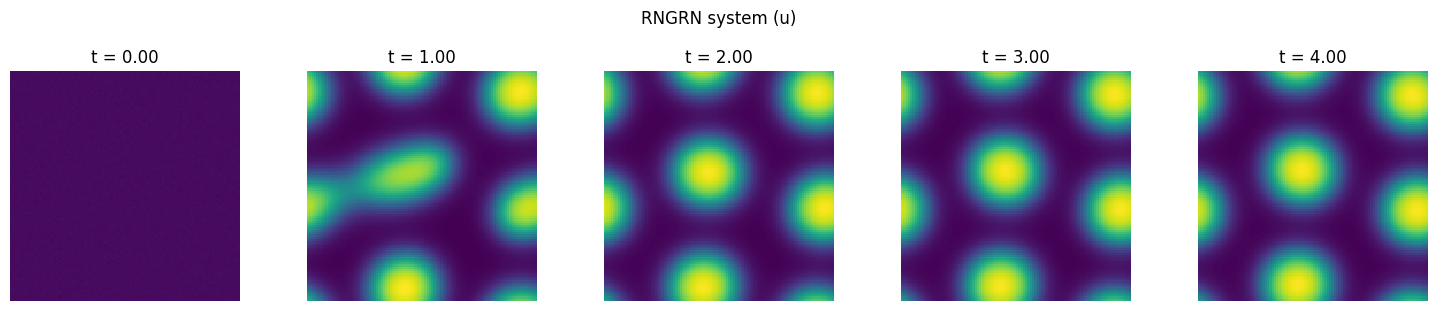

In [54]:
###Generate sample of simulation
#Sample frames 
num_snaps = len(trajectory_rngrn)
fractions = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
idxs = np.clip(np.round(fractions * (num_snaps - 1)).astype(int), 0, num_snaps - 1)

#Time per saved snap
dt_float = float(dt.item()) if hasattr(dt, "item") else float(dt)
times = idxs * dt_float

#Extract u frames 
u_frames = [trajectory_rngrn[i][:n_cells*n_cells].view(n_cells, n_cells).cpu().numpy() for i in idxs]

#Consistent colour scale 
vmin = min(frame.min() for frame in u_frames)
vmax = max(frame.max() for frame in u_frames)

#Plot u snapshots
fig, axes = plt.subplots(1, len(u_frames), figsize=(3*len(u_frames), 3))
for ax, fr, t in zip(axes, u_frames, times):
    ax.imshow(fr, origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f"t = {t:.2f}")
    ax.axis('off')
fig.suptitle('RNGRN system (u)', y=1.02)
plt.tight_layout()
plt.show()


## Simulate target system

In [55]:
###Simulation with target system
trajectory_target = bdf1_newton_krylov(X0, dt, Tmax, rhs_target, jvp_func=None, tol=1e-2, max_iter=5, gmres_max_iter=200, save_interval=100)


Simulation progress: step 1/399999
Newton converged in 2 iterations at step 1
Simulation progress: step 1001/399999
Newton converged in 2 iterations at step 1001
Simulation progress: step 2001/399999
Newton converged in 1 iterations at step 2001
Simulation progress: step 3001/399999
Newton converged in 1 iterations at step 3001
Simulation progress: step 4001/399999
Newton converged in 2 iterations at step 4001
Simulation progress: step 5001/399999
Newton converged in 2 iterations at step 5001
Simulation progress: step 6001/399999
Newton converged in 1 iterations at step 6001
Simulation progress: step 7001/399999
Newton converged in 1 iterations at step 7001
Simulation progress: step 8001/399999
Newton converged in 1 iterations at step 8001
Simulation progress: step 9001/399999
Newton converged in 2 iterations at step 9001
Simulation progress: step 10001/399999
Newton converged in 1 iterations at step 10001
Simulation progress: step 11001/399999
Newton converged in 1 iterations at step 

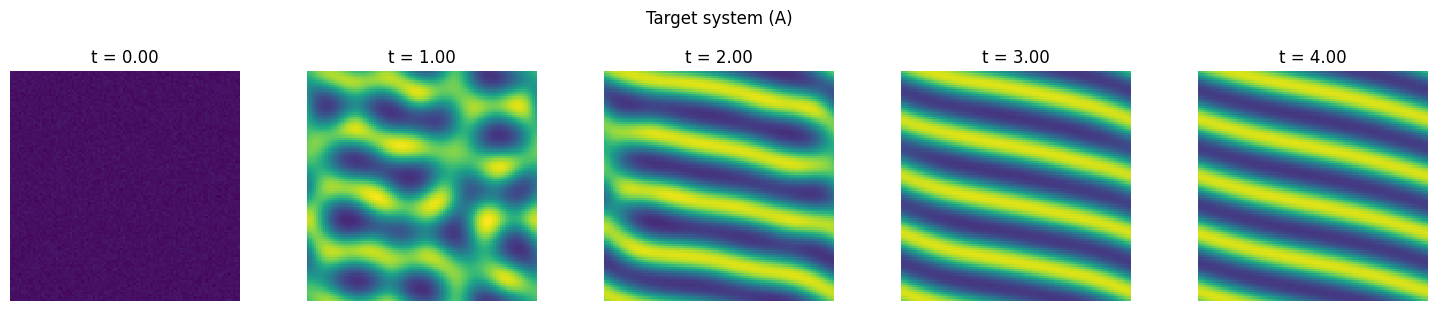

In [56]:
###Generate sample of simulation
#Sample frames 
num_snaps = len(trajectory_target)
fractions = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
idxs = np.clip(np.round(fractions * (num_snaps - 1)).astype(int), 0, num_snaps - 1)

#Time per saved snap
dt_float = float(dt.item()) if hasattr(dt, "item") else float(dt)
times = idxs * dt_float

#Extract u frames 
u_frames = [trajectory_target[i][:n_cells*n_cells].view(n_cells, n_cells).cpu().numpy() for i in idxs]

#Consistent colour scale 
vmin = min(frame.min() for frame in u_frames)
vmax = max(frame.max() for frame in u_frames)

#Plot u snapshots
fig, axes = plt.subplots(1, len(u_frames), figsize=(3*len(u_frames), 3))
for ax, fr, t in zip(axes, u_frames, times):
    ax.imshow(fr, origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f"t = {t:.2f}")
    ax.axis('off')
fig.suptitle('Target system (A)', y=1.02)
plt.tight_layout()
plt.show()


## Compare simulations

We can compare the MSE difference between the simulations.

Overall MSE between target A and RNGRN x1 over 4000 timepoints: 7.949705e+01


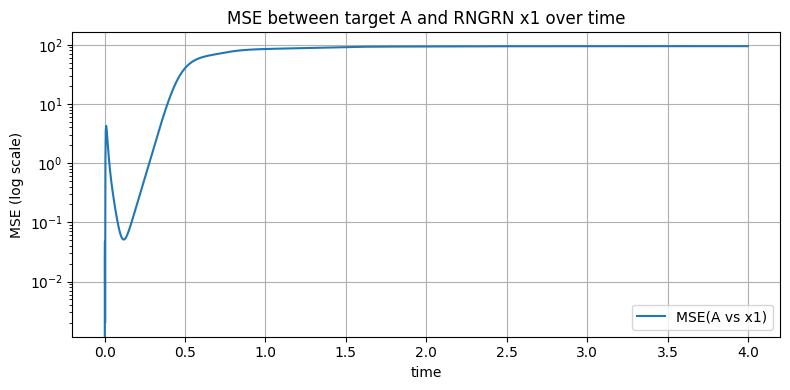

In [57]:
###Calculate MSE over time
T = min(len(trajectory_target), len(trajectory_rngrn))

n_nodes = n_cells * n_cells
mse_u_x1 = []

for i in range(T):
    u_t = trajectory_target[i][:n_nodes].cpu().float()         
    x_block = trajectory_rngrn[i][:N * n_nodes].cpu().float()  
    x1 = x_block[:n_nodes]                                     
    mse_u_x1.append(float(((u_t - x1) ** 2).mean().item()))

mse_u_x1 = np.array(mse_u_x1)
overall_mse = mse_u_x1.mean()
print(f"Overall MSE between target A and RNGRN x1 over {T} timepoints: {overall_mse:.6e}")

dt_float = float(dt.item()) if hasattr(dt, "item") else float(dt)
times = np.arange(T) * dt_float

plt.figure(figsize=(8,4))
plt.semilogy(times, mse_u_x1, label="MSE(A vs x1)")
plt.xlabel("time")
plt.ylabel("MSE (log scale)")
plt.title("MSE between target A and RNGRN x1 over time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Linear Stability Analysis

In [58]:
### Calculate steady states of target model

# Gierer-Meinhardt Parameters 
a = 0.5
b = 1.0
c = 6.1
K = 0.003
Du = 1.0
Dv = 100.0

# Calculate homogeneous steady state of saturated target model
def steady_state_eq(u):
    return a + c / (1 + K * u**2) - b * u

u_star = fsolve(steady_state_eq, x0=(a + c) / b)[0]
v_star = (u_star**2) / c

print(f"Steady state: u* = {u_star:.6f}, v* = {v_star:.6f}")


Steady state: u* = 6.004593, v* = 5.910679


In [59]:
### Linear stability analysis of target model
# Compute Jacobian matrix at steady state (reaction terms only)
f_u = (2 * u_star) / (v_star * (1 + K * u_star**2)**2) - b
f_v = -(u_star**2) / (v_star**2 * (1 + K * u_star**2))
g_u = 2 * u_star
g_v = -c

J = np.array([[f_u, f_v], 
              [g_u, g_v]])

# Create range of wavenumbers
k_values = np.linspace(0, 2, 200)

# Compute dispersion relation σ(k) for each k
growth_rates = []
for k in k_values:
    # Matrix J - k²D
    D_matrix = np.diag([Du, Dv])
    M = J - (k**2) * D_matrix
    
    # Growth rate is the maximum real part of eigenvalues
    eigenvalues = np.linalg.eigvals(M)
    max_growth = np.max(np.real(eigenvalues))
    growth_rates.append(max_growth)

growth_rates = np.array(growth_rates)

# Find k_max from computed dispersion relation
k_max_idx = np.argmax(growth_rates)
k_max = k_values[k_max_idx]
max_growth = growth_rates[k_max_idx]

In [ ]:
### Linear stability analysis of RNGRN model 

# Helper function to convert tensors to numpy
def to_numpy(tensor):
    return tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor

# Convert all parameters to numpy
kA_plus_np, kA_minus_np = to_numpy(kA_plus), to_numpy(kA_minus)
kR_plus_np, kR_minus_np = to_numpy(kR_plus), to_numpy(kR_minus)
mu_np = to_numpy(mu)
KA, KR = to_numpy(KA_mat), to_numpy(KR_mat)
alpha_rngrn, delta_rngrn, beta_rngrn = to_numpy(alpha), to_numpy(delta), to_numpy(beta)
D_rngrn = to_numpy(D)

n_species = 2
EPS = 1e-5  

# Identify active G variables
active_GA = [(i, j) for i in range(n_species) for j in range(n_species) 
             if kA_plus_np[i, j] > EPS or kA_minus_np[i, j] > EPS]
active_GR = [(i, j) for i in range(n_species) for j in range(n_species) 
             if kR_plus_np[i, j] > EPS or kR_minus_np[i, j] > EPS]

n_active_GA, n_active_GR = len(active_GA), len(active_GR)
n_effective = n_species + n_active_GA + n_active_GR

# Helper to unpack state vector
def unpack_state(state_reduced):
    x = state_reduced[:n_species]
    G_A = np.zeros((n_species, n_species))
    G_R = np.zeros((n_species, n_species))
    
    idx = n_species
    for (i, j) in active_GA:
        G_A[i, j] = state_reduced[idx]
        idx += 1
    for (i, j) in active_GR:
        G_R[i, j] = state_reduced[idx]
        idx += 1
    
    return x, G_A, G_R

# Steady state equations for reduced system
def reduced_rngrn_steady_state_eqs(state_reduced):
    x, G_A, G_R = unpack_state(state_reduced)
    G_free = 1.0 - G_A.sum(axis=1) - G_R.sum(axis=1)
    eqs = np.zeros(n_effective)
    
    # x dynamics
    eqs[:n_species] = beta_rngrn + (alpha_rngrn * G_A).sum(axis=1) - delta_rngrn * x
    
    # Active G_A dynamics
    idx = n_species
    for (i, j) in active_GA:
        eqs[idx] = (kA_plus_np[i, j] * x[j]**2 * G_free[i] - kA_minus_np[i, j] * G_A[i, j]) / mu_np
        idx += 1
    
    # Active G_R dynamics
    for (i, j) in active_GR:
        eqs[idx] = (kR_plus_np[i, j] * x[j]**2 * G_free[i] - kR_minus_np[i, j] * G_R[i, j]) / mu_np
        idx += 1
    
    return eqs

# Initialize state vector
x0_guess = np.array([6.6, 7.1])
state0_reduced = np.zeros(n_effective)
state0_reduced[:n_species] = x0_guess

# Initialize G variables from quasi-steady state
x_squared = x0_guess**2
idx = n_species
for i in range(n_species):
    denom = 1.0 + np.sum(KA[i, :] * x_squared) + np.sum(KR[i, :] * x_squared)
    for (gi, gj) in active_GA:
        if gi == i:
            state0_reduced[idx] = (KA[i, gj] * x_squared[gj]) / denom
            idx += 1
    for (gi, gj) in active_GR:
        if gi == i:
            state0_reduced[idx] = (KR[i, gj] * x_squared[gj]) / denom
            idx += 1

# Solve for steady state
state_star = fsolve(reduced_rngrn_steady_state_eqs, state0_reduced)
x_star_full, G_A_star, G_R_star = unpack_state(state_star)

# Compute Jacobian at steady state
def compute_effective_rngrn_jacobian(state_reduced):
    x, G_A, G_R = unpack_state(state_reduced)
    G_free = 1.0 - G_A.sum(axis=1) - G_R.sum(axis=1)
    J_eff = np.zeros((n_effective, n_effective))
    
    # x equation derivatives
    np.fill_diagonal(J_eff[:n_species, :n_species], -delta_rngrn)
    
    for idx_g, (gi, gj) in enumerate(active_GA):
        J_eff[gi, n_species + idx_g] = alpha_rngrn[gi, gj]
    
    # Active G_A equation derivatives
    for idx_row, (i, j) in enumerate(active_GA):
        row = n_species + idx_row
        J_eff[row, j] = (2 * kA_plus_np[i, j] * x[j] * G_free[i]) / mu_np
        
        for idx_col, (ci, cj) in enumerate(active_GA):
            if ci == i:
                J_eff[row, n_species + idx_col] = -kA_plus_np[i, j] * x[j]**2 / mu_np
        for idx_col, (ci, cj) in enumerate(active_GR):
            if ci == i:
                J_eff[row, n_species + n_active_GA + idx_col] = -kA_plus_np[i, j] * x[j]**2 / mu_np
        
        # Self degradation
        J_eff[row, row] -= kA_minus_np[i, j] / mu_np
    
    # Active G_R equation derivatives
    for idx_row, (i, j) in enumerate(active_GR):
        row = n_species + n_active_GA + idx_row
        J_eff[row, j] = (2 * kR_plus_np[i, j] * x[j] * G_free[i]) / mu_np
        
        # G_free coupling terms
        for idx_col, (ci, cj) in enumerate(active_GA):
            if ci == i:
                J_eff[row, n_species + idx_col] = -kR_plus_np[i, j] * x[j]**2 / mu_np
        for idx_col, (ci, cj) in enumerate(active_GR):
            if ci == i:
                J_eff[row, n_species + n_active_GA + idx_col] = -kR_plus_np[i, j] * x[j]**2 / mu_np
        
        # Self degradation
        J_eff[row, row] -= kR_minus_np[i, j] / mu_np
    
    return J_eff

J_full = compute_effective_rngrn_jacobian(state_star)

# Diffusion vector (only x variables diffuse)
D_eff = np.zeros(n_effective)
D_eff[:n_species] = D_rngrn

print(f"Effective Jacobian shape: {J_full.shape}")
eigenvalues = np.linalg.eigvals(J_full)
print(f"Jacobian eigenvalues (real parts): {np.sort(np.real(eigenvalues))[::-1]}")
print(f"tr(J) = {np.trace(J_full):.6f}, det(J) = {np.linalg.det(J_full):.6e}")

# Compute dispersion relation σ(k)
k_values_rngrn = np.linspace(0, 2, 200)
growth_rates_rngrn = np.array([
    np.max(np.real(np.linalg.eigvals(J_full - k**2 * np.diag(D_eff))))
    for k in k_values_rngrn
])

k_max_idx_rngrn = np.argmax(growth_rates_rngrn)
k_max_rngrn = k_values_rngrn[k_max_idx_rngrn]
max_growth_rngrn = growth_rates_rngrn[k_max_idx_rngrn]


Effective Jacobian shape: (6, 6)
Jacobian eigenvalues (real parts): [-1.77256691e-01 -9.89873009e-01 -1.77207955e+01 -1.23805808e+02
 -7.35223125e+02 -8.68307754e+02]
tr(J) = -1746.224612, det(J) = 2.457532e+08


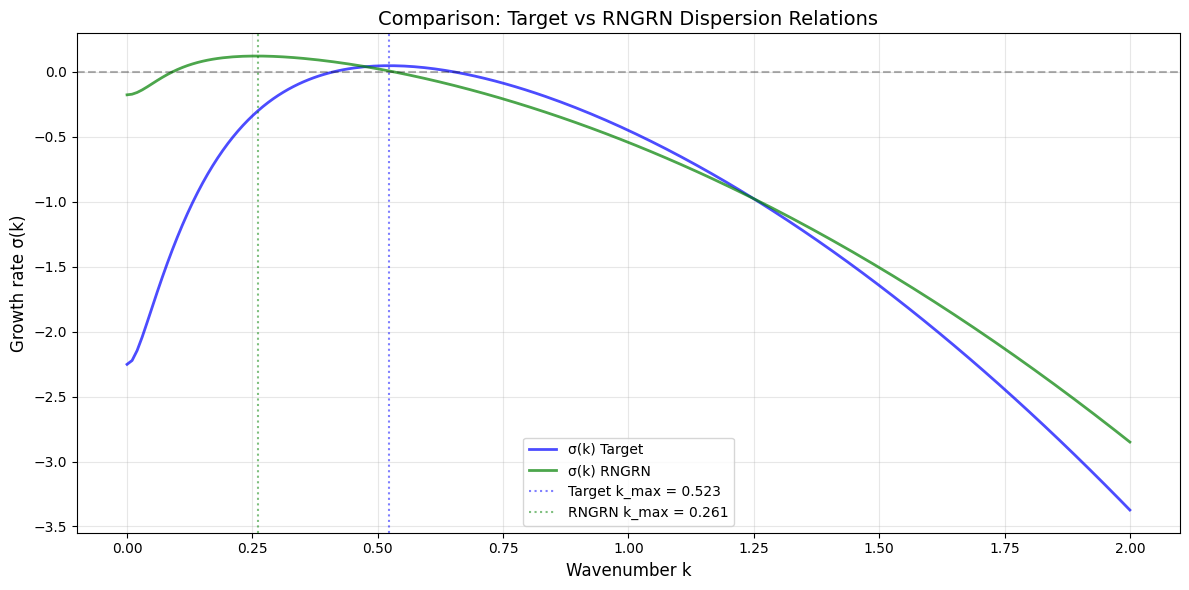

Target k_max: 0.522613, wavelength: 12.022633
RNGRN k_max:  0.261307, wavelength: 24.045267

Target max growth rate: 0.047119
RNGRN max growth rate:  0.121385

Difference in k_max: 0.074266


In [61]:
### Target vs RNGRN dispersion relations

plt.figure(figsize=(12, 6))

# Plot both dispersion relations
plt.plot(k_values, growth_rates, 'b-', linewidth=2, label='σ(k) Target', alpha=0.7)
plt.plot(k_values_rngrn, growth_rates_rngrn, 'g-', linewidth=2, label='σ(k) RNGRN', alpha=0.7)

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=k_max, color='blue', linestyle=':', alpha=0.5, 
            label=f'Target k_max = {k_max:.3f}')
plt.axvline(x=k_max_rngrn, color='green', linestyle=':', alpha=0.5, 
            label=f'RNGRN k_max = {k_max_rngrn:.3f}')

plt.xlabel('Wavenumber k', fontsize=12)
plt.ylabel('Growth rate σ(k)', fontsize=12)
plt.title('Comparison: Target vs RNGRN Dispersion Relations', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"Target k_max: {k_max:.6f}, wavelength: {2*np.pi/k_max:.6f}")
print(f"RNGRN k_max:  {k_max_rngrn:.6f}, wavelength: {2*np.pi/k_max_rngrn:.6f}")
print(f"\nTarget max growth rate: {growth_rates[k_max_idx]:.6f}")
print(f"RNGRN max growth rate:  {growth_rates_rngrn[k_max_idx_rngrn]:.6f}")
print(f"\nDifference in k_max: {abs(growth_rates[k_max_idx] - growth_rates_rngrn[k_max_idx_rngrn]):.6f}")
